# Clinical Data ETL Pipeline

This notebook extracts clinical data from different database sources, transforms it, and loads it into staging tables for further analysis. The pipeline focuses on ward stays, vitals, diagnostics, labs, and demographics data from hospital systems.

## Pipeline Overview
1. Connect to source databases via SSH tunnels
2. Extract raw clinical data
3. Transform and clean data
4. Load into staging tables
5. Perform data quality checks

## Imports and Setup
Import required libraries and set up the environment

In [1]:
# Import required libraries for PostgreSQL connections and data processing

import json
from sshtunnel import SSHTunnelForwarder
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import sys
from sqlalchemy import inspect
import pandas as pd
import os
import json
import sys

ROOT_PATH = "/Users/xaviborrat/Documents/GitHub/TFM_Clinical_Deterioration"

sys.path.append(ROOT_PATH)
# Import custom database connection class
import classes
from classes.xavi_con_class import db_connect as xcc

## Database Connections
Establish connections to various database systems using SSH tunneling

In [2]:
# MySQL Connection
# Connect to datanex database via SSH using configuration from config_mysql.json

config_path = os.path.join(ROOT_PATH, 'classes/config_mysql.json')
with open(config_path, 'r') as configDnx:
    configDnx = json.load(configDnx)

datanex = xcc(
    ssh = configDnx["ssh"],
    ssh_user = configDnx["ssh_user"],
    ssh_host = configDnx["ssh_host"],
    ssh_pkey = configDnx["ssh_pkey"],
    db_host = configDnx["db_host"],
    db_port = configDnx["db_port"],
    db_user = configDnx["db_user"],
    db_pass = configDnx["db_pass"],
    flavour = configDnx["flavour"],
    db = configDnx["db"]
)

In [13]:
datanex.query('borrat_project',"""Select count(distinct patient_ref) from ward_stays""")

Database [borrat_project] session created...
<> Query Sucessful <>


,count(distinct patient_ref)
0,18989


In [5]:
# TFM Connection
# Connect to TFM database via SSH using configuration from config_tfm.json

config_path = os.path.join(ROOT_PATH, 'classes/config_tfm.json')
with open(config_path, 'r') as configTfm:
    configTfm = json.load(configTfm)

datanex = xcc(
    ssh = configTfm["ssh"],
    ssh_user = configTfm["ssh_user"],
    ssh_host = configTfm["ssh_host"],
    ssh_pkey = configTfm["ssh_pkey"],
    db_host = configTfm["db_host"],
    db_port = configTfm["db_port"],
    db_user = configTfm["db_user"],
    db_pass = configTfm["db_pass"],
    flavour = configTfm["flavour"],
    db = configTfm["db"]
)

## Data Validation
Verify database connection and check schema

In [7]:
# Validate connection and inspect schema
df = datanex.query('borrat_project', "select * from ward_stays_ds limit 10")
df.columns

Database [borrat_project] session created...
<> Query Sucessful <>


Index(['stay_id', 'episode_ref', 'care_level_ref', 'start_date', 'end_date',
       'care_level_type_ref', 'ou_med_ref', 'seq_num', 'next_care_level',
       'to_icu', 'icu_los', 'hosp_adm_date', 'hosp_disch_date', 'hosp_los',
       'hosp_mortality_bin', 'hosp_mortality_date',
       'discharge_to_dead_interval', 'patient_ref', 'age_on_admission'],
      dtype='object')

## Ward Stays Data Pipeline
Create the ward_stays table that tracks patient movements between wards and ICUs.
The table includes information about:
- Patient and episode references
- Ward admission and discharge dates
- ICU transfers and length of stay
- Hospital mortality

In [9]:
# WARD_STAYS
# Create the ward_stays table in datanex server borrat_project schema

datanex.query_build('datascope4', """DROP TABLE IF EXISTS borrat_project.ward_stays""")
datanex.query_build('datascope4', """ 
    
    CREATE TABLE IF NOT EXISTS borrat_project.ward_stays AS (
        WITH stay_year_filter AS (
    -- Filter for relevant date range
    SELECT 
        patient_ref,
        episode_ref,
        care_level_ref,
        start_date,
        end_date,
        care_level_type_ref,
        ou_loc_descr,
        ou_loc_ref,
        ou_med_ref
    FROM datascope4.g_movements
    WHERE start_date >= '2022-01-01' AND start_date < '2023-01-01'
      AND facility = 'VILLARROEL'
      AND care_level_type_ref IN ('WARD', 'ICU')
),
    
mov_colap AS (
    -- Collapse movements to get min/max dates
    SELECT
        patient_ref,
        episode_ref,
        care_level_ref,
        MIN(start_date) AS start_date,
        MAX(end_date) AS end_date,
        MAX(care_level_type_ref) AS care_level_type_ref, 
        MAX(ou_loc_descr) AS ou_loc_descr,
        MAX(ou_loc_ref) AS ou_loc_ref,
        MAX(ou_med_ref) AS ou_med_ref
    FROM stay_year_filter
    GROUP BY patient_ref, episode_ref, care_level_ref
),
    
-- Calculate window functions for stay sequencing
stay_window_calc AS (
    SELECT
        mc.*,
        RANK() OVER (
            PARTITION BY patient_ref, episode_ref
            ORDER BY patient_ref, start_date
        ) AS seq_num,
        LEAD(care_level_type_ref) OVER (
            PARTITION BY patient_ref, episode_ref
            ORDER BY patient_ref, episode_ref, care_level_ref, start_date
        ) AS next_care_level,
        LEAD(start_date) OVER (
            PARTITION BY patient_ref, episode_ref
            ORDER BY patient_ref, episode_ref, care_level_ref, start_date
        ) AS next_start_date,
        LEAD(end_date) OVER (
            PARTITION BY patient_ref, episode_ref
            ORDER BY patient_ref, episode_ref, care_level_ref, start_date
        ) AS next_end_date
    FROM mov_colap mc
),

new_stay AS (
    -- Identify transfers to ICU and calculate ICU length of stay
    SELECT
        swc.*,
        CASE 
            WHEN care_level_type_ref <> 'ICU' AND next_care_level = 'ICU' THEN 1
            ELSE 0 
        END AS to_icu,
        CASE 
            WHEN next_care_level = 'ICU' 
            THEN DATEDIFF(next_end_date, next_start_date)
        END AS icu_los
    FROM stay_window_calc swc
),

-- Add hospital episode data
new_stay_hosp_los AS (
    SELECT
        ns.*,
        epi.start_date AS hosp_adm_date,
        epi.end_date AS hosp_disch_date,
        DATEDIFF(epi.end_date, epi.start_date) AS hosp_los
    FROM new_stay ns
    JOIN g_episodes epi USING (episode_ref)
),

-- Add mortality data
new_stay_mortality AS (
    SELECT
        los.*,
        CASE
            WHEN ee.exitus_date IS NOT NULL 
                 AND ee.exitus_date >= los.hosp_adm_date 
                 AND ee.exitus_date <= DATE_ADD(los.hosp_disch_date, INTERVAL 1 DAY) 
            THEN 1
            ELSE 0
        END AS hosp_mortality_bin,
        ee.exitus_date AS hosp_mortality_date,
        CASE 
            WHEN ee.exitus_date IS NOT NULL 
            THEN DATEDIFF(ee.exitus_date, los.hosp_disch_date)
        END AS discharge_to_dead_interval
    FROM new_stay_hosp_los los
    LEFT JOIN g_exitus ee ON los.patient_ref = ee.patient_ref
),

-- Add stay_id and finalize dataset
ward_stays AS (
    SELECT
        nm.*,
        ROW_NUMBER() OVER (ORDER BY start_date) AS stay_id
       
        
    FROM new_stay_mortality nm
    -- WHERE care_level_type_ref = 'WARD'
)
SELECT  stay_id, patient_ref, episode_ref, care_level_ref, start_date,
       end_date, care_level_type_ref, 
       ou_med_ref, seq_num, next_care_level, 
        to_icu, icu_los, hosp_adm_date,
        hosp_disch_date, hosp_los, hosp_mortality_bin,
        hosp_mortality_date, discharge_to_dead_interval
        FROM ward_stays 
        order by patient_ref, start_date
)
""")

Database [datascope4] session created...
<> Query executed Sucessfully <>
Database [datascope4] session created...
<> Query executed Sucessfully <>


## Vital Signs Data Pipeline
Create the vitals table that contains patient vital signs measurements.
- Filters for relevant vital sign parameters
- Links measurements to ward stays
- Normalizes variable names for consistency
- Excludes intraoperative measurements

In [ ]:
#---- VITALS ----
# Create vitals table in datanex server borrat_project schema
datanex.query_build('datascope4', """DROP TABLE IF EXISTS borrat_project.vitals""")

datanex.query_build('datascope4', """

-- Filter for relevant clinical records
CREATE TABLE IF NOT EXISTS borrat_project.vitals AS (
with relevant_rc AS (
    SELECT 
        grc.patient_ref,
        grc.result_date,
        grc.rc_sap_ref,
        grc.result_num,
        grc.result_txt,
        grc.rc_descr
    FROM datascope4.g_rc grc
    JOIN (SELECT DISTINCT patient_ref FROM borrat_project.ward_stays) p
      ON grc.patient_ref = p.patient_ref
    WHERE grc.result_date >= '2022-01-01'
      AND grc.result_date < '2023-01-01'
      AND grc.rc_sap_ref IN ( -- Selected relevant variables and merged similar entities
                    'TALLA',

                  
                 
                    'OXIGEN',
                    'VIA_AEREA_MOD',
                    'CAR_RITM',
              
                    'PA_S'
                    'COMA_GCS',
                    'PA_S',
                    'PESO',
                    'FIO2',
                    'NEWS_2_WA',
                    'DOLOR_LOC',
                    'O2_Q',
                    'PANI_M',
                    'TEMP_TIM',
                    'FC_EKG',
                    'NEWS_2_MS',
                    'GLIC_CAPIL',
                    'NEWS_2',
                    'TEMP_CT',
                    'TEMP_AXI',
                    'EPOC',
                    'PULSO',
                    'FR_IP',
                    'FREC_RESP',
                    'O2_DIS',
                    'ESTADO_CONCIENC',
                    'FC_OSC',
                    'DOLOR_ENO',
                    'PULSIOX',
                    'PRESN_DIA',
                    'NEWS_2_VIG',
                    'PRESN_SIS')
),
vitals_full AS (
-- Join with ward stays
SELECT
    ws.stay_id,
    ws.patient_ref,
    -- ws.ou_med_ref,
    rc.result_date,
    rc.rc_sap_ref,
    rc.result_num,
    rc.result_txt
    
FROM borrat_project.ward_stays ws
    INNER JOIN relevant_rc rc
    ON ws.patient_ref = rc.patient_ref
    WHERE ws.care_level_type_ref = 'WARD' 
    AND rc.result_date BETWEEN ws.start_date AND ws.end_date
    ),
   -- Filter out intraoperative vital signs (exclude first-last VM values)
  marques AS(
    SELECT
        stay_id,
        MIN(result_date) AS primer_valor_vm,
        MAX(result_date) AS ultim_valor_vm
    FROM vitals_full
    WHERE rc_sap_ref LIKE "VMA%%"
    GROUP BY stay_id
)
                    

select    v.stay_id,
          v.patient_ref,
          v.result_date,

          v.result_num,
          v.result_txt,
            
  CASE -- Normalize variable names for consistency
    WHEN rc_sap_ref = 'PA_S'       THEN 'P_ART_S'
    WHEN rc_sap_ref = 'NEWS_2_WA'   THEN 'NEWS_2'
    WHEN rc_sap_ref = 'PANI_M'      THEN 'P_ART_M'
    WHEN rc_sap_ref = 'TEMP_TIM'    THEN 'TEMP'
    WHEN rc_sap_ref = 'FC_EKG'      THEN 'FC'
    WHEN rc_sap_ref = 'NEWS_2_MS'   THEN 'NEWS_2'
    WHEN rc_sap_ref = 'TEMP_CT'     THEN 'TEMP'
    WHEN rc_sap_ref = 'TEMP_AXI'    THEN 'TEMP'
    WHEN rc_sap_ref = 'PULSO'       THEN 'FC'
    WHEN rc_sap_ref = 'FR_IP'       THEN 'FR'
    WHEN rc_sap_ref = 'FREC_RESP'   THEN 'FR'
    WHEN rc_sap_ref = 'FC_OSC'      THEN 'FC'
    WHEN rc_sap_ref = 'PRESN_DIA'   THEN 'P_ART_D'
    WHEN rc_sap_ref = 'PRESN_SIS'   THEN 'P_ART_S'
    ELSE rc_sap_ref
  END AS rc_sap_ref

from vitals_full v
left join marques m
  on v.stay_id = m.stay_id
WHERE m.primer_valor_vm IS NULL OR v.result_date < m.primer_valor_vm OR v.result_date > m.ultim_valor_vm

  
)
"""
)

Database [datascope4] session created...
<> Query executed Sucessfully <>
Database [datascope4] session created...
<> Query executed Sucessfully <>


## Data Quality Check
Verify data consistency between ward_stays and vitals tables

In [ ]:
# Verify count of distinct stay_ids in both tables

print(datanex.query('datascope4', """
SELECT count(distinct stay_id) from borrat_project.ward_stays where care_level_type_ref = 'WARD'"""))
print(datanex.query('datascope4', """select count(distinct stay_id) from borrat_project.vitals"""))

Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct stay_id)
0                    25138
Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct stay_id)
0                    24721


In [ ]:
# Export distribution of vitals counts per stay to CSV for analysis
datanex.query('datascope4', """
SELECT stay_id, count(*) from borrat_project.vitals group by stay_id """).sort_values('count(*)', ascending=False).to_csv('stay.csv')

Database [datascope4] session created...
<> Query Sucessful <>


## Diagnostics Data Pipeline
Create the diagnostics table with ICD-10 codes for patient conditions.
- Filters for primary and secondary diagnoses
- Links to patient episodes

In [ ]:
#-------------------DIAGNOSTICS-----------------------------------------------------------

datanex.query_build('datascope4', """DROP TABLE IF EXISTS borrat_project.diagnostics;""")

datanex.query_build('datascope4', """

CREATE TABLE borrat_project.diagnostics as (
    -- Extract diagnosis codes from relevant episodes
    SELECT gdg.episode_ref, gdg.code as icd10_code, gdg.class, gdg.poa
    FROM datascope4.g_diagnostics gdg
    JOIN (SELECT DISTINCT episode_ref FROM borrat_project.ward_stays) p
    ON gdg.episode_ref = p.episode_ref
    where catalog in (11,12,13)  
    and class in ('P','S') -- Primary and Secondary diagnoses only
)
""")

Database [datascope4] session created...
<> Query executed Sucessfully <>
Database [datascope4] session created...
<> Query executed Sucessfully <>


In [ ]:
# Data quality check for diagnostics table
# Verify all episodes from ward_stays are represented in diagnostics

print(datanex.query('datascope4', """ 
SELECT count(distinct episode_ref) from borrat_project.ward_stays """))

print(datanex.query('datascope4', """select count(distinct episode_ref) from borrat_project.diagnostics"""))

Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct episode_ref)
0                        23999
Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct episode_ref)
0                        23885


## Laboratory Results Data Pipeline
Create the labs table with patient laboratory test results.
- Filters for relevant time period
- Links lab results to ward stays

In [ ]:
# --------------------LABS--------------------------------
datanex.query_build('datascope4', """DROP TABLE IF EXISTS borrat_project.labs;""")
datanex.query_build('datascope4', """
CREATE TABLE IF NOT EXISTS borrat_project.labs AS 
with relevant_labs AS (
    -- Extract lab results for patients in ward_stays
    SELECT 
        l.patient_ref,
        l.episode_ref,
        l.extrac_date,
        l.lab_sap_ref,
        l.result_num,
        l.result_txt
        
    FROM datascope4.g_labs l
    JOIN (SELECT DISTINCT patient_ref FROM borrat_project.ward_stays) p
      ON l.patient_ref = p.patient_ref
    WHERE l.result_date >= '2022-01-01'
      AND l.result_date < '2023-01-01'
)

-- Join with ward stays and filter for results during stay period
SELECT
    ws.stay_id,
    l.patient_ref,
    l.extrac_date,
    l.lab_sap_ref,
    l.result_num,
    l.result_txt
FROM borrat_project.ward_stays ws
INNER JOIN relevant_labs l
    ON ws.patient_ref = l.patient_ref
    WHERE l.extrac_date BETWEEN ws.start_date AND ws.end_date
    AND ws.care_level_type_ref = 'WARD';
    

"""
)                   

Database [datascope4] session created...
<> Query executed Sucessfully <>
Database [datascope4] session created...
<> Query executed Sucessfully <>


In [ ]:
# Data quality check for labs table
# Verify stay coverage

print(datanex.query('datascope4', """
SELECT count(distinct stay_id) from borrat_project.ward_stays where care_level_type_ref = 'WARD'"""))
print(datanex.query('datascope4', """select count(distinct stay_id) from borrat_project.labs"""))

Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct stay_id)
0                    25138
Database [datascope4] session created...
<> Query Sucessful <>
   count(distinct stay_id)
0                    19531


## Demographics Data Pipeline
Create the demographics table with patient demographic information.
- Extracts birth date, sex, and nationality
- Links to patients in ward_stays table

In [15]:
#--------------Demographics-----------------------------

datanex.query_build('datascope4', """DROP TABLE IF EXISTS borrat_project.demographics;""")
datanex.query_build('datascope4', """
CREATE TABLE IF NOT EXISTS borrat_project.demographics AS 
    SELECT 
        d.patient_ref,
        d.birth_date,
        d.sex,
        d.natio_ref
      
    FROM datascope4.g_demographics d
    JOIN (SELECT DISTINCT patient_ref FROM borrat_project.ward_stays where care_level_type_ref = 'WARD') p
      ON d.patient_ref = p.patient_ref

""")

Database [datascope4] session created...
<> Query executed Sucessfully <>
Database [datascope4] session created...
<> Query executed Sucessfully <>


## Data Analysis
Explore vital signs data distribution

In [ ]:
# Get count of vital measurements per stay
vitals_iq = datanex.query("borrat_project", """SELECT stay_id, count(*) as contador from borrat_project.vitals group by stay_id
                           order by contador desc""")

Database [test] session created...
<> Query Sucessful <>


In [ ]:
# Descriptive statistics of vital sign counts
vitals_iq.contador.describe()

count    24727.000000
mean       274.887208
std        354.215078
min          1.000000
25%         75.000000
50%        165.000000
75%        320.000000
max       7133.000000
Name: contador, dtype: float64

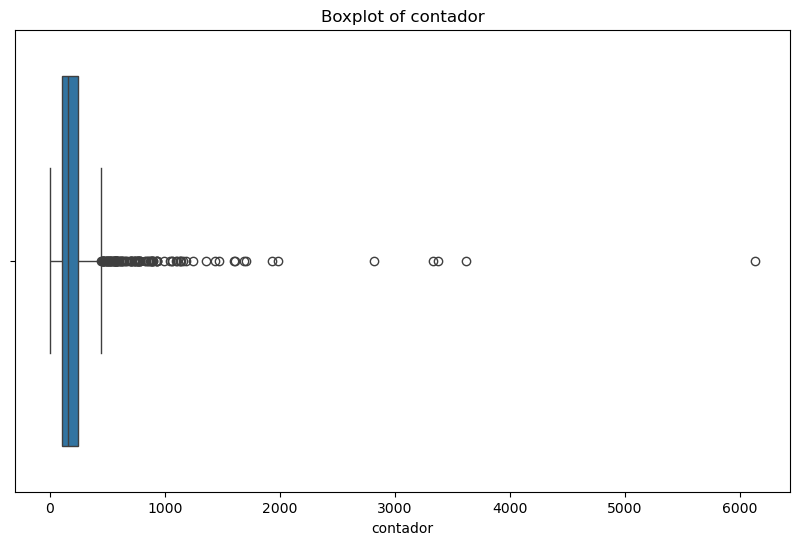

In [ ]:
# Create boxplot of vitals count distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=vitals_iq.contador)
plt.title('Distribution of Vital Signs Measurements per Stay')
plt.xlabel('Number of Measurements')
plt.show()

In [ ]:
# Examine vitals inventory
vitals_inventory = datanex.query("borrat_project", """SELECT rc_sap_ref, count(*) as count 
                                   FROM borrat_project.vitals 
                                   GROUP BY rc_sap_ref 
                                   ORDER BY count DESC""")
vitals_inventory.head(50)

,rc_sap_ref,contador
0,PULSIOX,562367
1,PRESN_SIS,562062
2,PRESN_DIA,561425
3,DOLOR_ENO,472106
4,FC_OSC,465350
5,ESTADO_CONCIENC,430407
6,O2_DIS,310865
7,FREC_RESP,305187
8,FR_IP,291754
9,PULSO,266985
